# Problem Statement
A Medical Insurance company “XYZ Healthcare Group” wants to predict the Medical insurance cost against various categories. They have shared details of other customers.
Now, they want to build a model to predict the Medical insurance cost of customer against various features which will help them to create personalized offer for customers.

## Importing Libraries

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error,mean_absolute_error,r2_score

## Importing Data

In [91]:
## Using kaggle
# import os
# for dirname, _, filenames in os.walk('/kaggle/input/insurance/'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))
# insurance_df = pd.read_csv('../input/insurance/insurance.csv')
# insurance_df.head()

## Using local data
insurance_df = pd.read_csv('insurance.csv',header="infer",sep=",")
insurance_df.head(1)

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.9,0,yes,southwest,16884.924


## Descriptive Statistics on Data

In [4]:
insurance_df.shape
print("Data has {n} rows and {m} columns".format(n=insurance_df.shape[0],m=insurance_df.shape[1]))

Data has 1338 rows and 7 columns


In [5]:
insurance_df.head()

,age,sex,bmi,children,smoker,region,charges
0,19,female,27.900,0,yes,southwest,16884.92400
1,18,male,33.770,1,no,southeast,1725.55230
2,28,male,33.000,3,no,southeast,4449.46200
3,33,male,22.705,0,no,northwest,21984.47061
4,32,male,28.880,0,no,northwest,3866.85520


In [6]:
insurance_df.tail()

,age,sex,bmi,children,smoker,region,charges
1333,50,male,30.97,3,no,northwest,10600.5483
1334,18,female,31.92,0,no,northeast,2205.9808
1335,18,female,36.85,0,no,southeast,1629.8335
1336,21,female,25.80,0,no,southwest,2007.9450
1337,61,female,29.07,0,yes,northwest,29141.3603


In [7]:
insurance_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1338 entries, 0 to 1337
Data columns (total 7 columns):
age         1338 non-null int64
sex         1338 non-null object
bmi         1338 non-null float64
children    1338 non-null int64
smoker      1338 non-null object
region      1338 non-null object
charges     1338 non-null float64
dtypes: float64(2), int64(2), object(3)
memory usage: 73.3+ KB


> - All features have 1338 rows implies No missing data
> - dtypes are in 2 int,3 object,2 float.

In [8]:
insurance_df.describe()

,age,bmi,children,charges
count,1338.000000,1338.000000,1338.000000,1338.000000
mean,39.207025,30.663397,1.094918,13270.422265
std,14.049960,6.098187,1.205493,12110.011237
min,18.000000,15.960000,0.000000,1121.873900
25%,27.000000,26.296250,0.000000,4740.287150
50%,39.000000,30.400000,1.000000,9382.033000
75%,51.000000,34.693750,2.000000,16639.912515
max,64.000000,53.130000,5.000000,63770.428010


> - Out of the all features, we see the 4 numeric fields here. Count is same for all.
> - Age looks like data for adults only 18-64 age, children 0-5 nos.
> - charges seems to have outliers as mean > median(50%) and also max > 1.5*(IQR) => right skewed data
> - bmi seems to have outliers as max > 1.5*(IQR)

In [9]:
insurance_df.describe(include=np.object)

,sex,smoker,region
count,1338,1338,1338
unique,2,2,4
top,male,no,southeast
freq,676,1064,364


> - Sex is binary of which male count is more it seems.
> - More no. of Non-smokers are present.
> - The data predominantly has southeast region data.

## Exploratory Data Analysis

### Duplicate Record Handling

In [10]:
insurance_df.duplicated().any().sum() # 1 duplicate record found

1

In [11]:
insurance_df[insurance_df.duplicated()] # this row is duplicated in the data

,age,sex,bmi,children,smoker,region,charges
581,19,male,30.59,0,no,northwest,1639.5631


In [12]:
insurance_df.drop_duplicates(inplace=True)

In [13]:
insurance_df.shape

(1337, 7)

The duplicate record at index 581 has been removed.

### Missing values Handling

In [77]:
insurance_df.isna().sum()

age            0
sex            0
bmi            0
children       0
smoker         0
region      1337
charges        0
dtype: int64

No missing value found as also seen from descriptive Statistics

### Outlier Handling

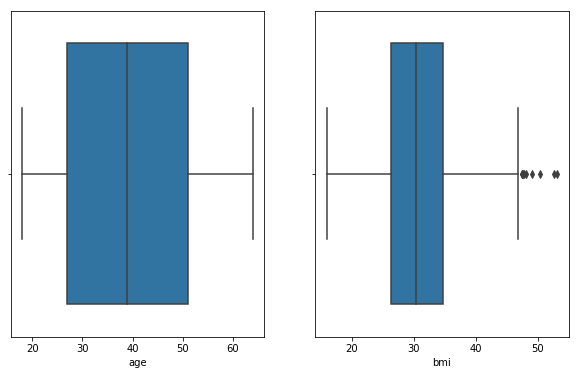

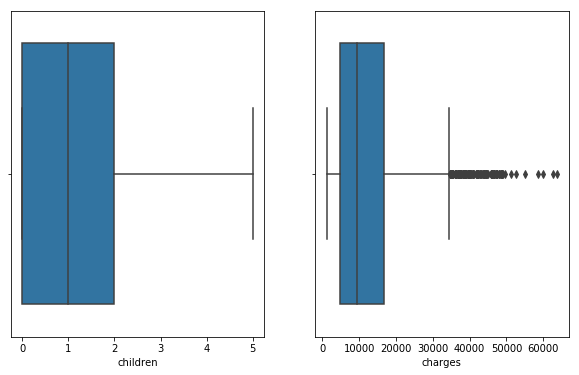

In [15]:
fig, (ax1,ax2) = plt.subplots(ncols=2, figsize=(10,6))
fig, (ax3,ax4) = plt.subplots(ncols=2, figsize=(10,6))

sns.boxplot(insurance_df['age'],ax=ax1)
sns.boxplot(insurance_df['bmi'],ax=ax2)
sns.boxplot(insurance_df['children'],ax=ax3)
sns.boxplot(insurance_df['charges'],ax=ax4)
plt.show()

> - We find no outliers in Age,Children. But outliers are present for bmi and charges
> - We know the outliers can be calculated using diff ways : IQR,std and z_score
>> - In IQR , Lower bound = Q1 – (1.5 * IQR) and Upper bound = Q3 + (1.5 * IQR) is an outlier
>> - In std way, outlier_high = df.column.mean() + 3*(df.column.std()), outlier_low = df.column.mean() - 3*(df.column.std())is an outlier
>> - In Z_score way, we do zscore calculation with stats library and get all records beyond 3.

#### IQR way

In [16]:
Q1 = insurance_df['charges'].quantile(.25)
Q3 = insurance_df['charges'].quantile(.75)
IQR = Q3 - Q1
insurance_df[(insurance_df[['charges']] > (Q3+1.5*IQR)) | (insurance_df[['charges']] < (Q1 - 1.5*IQR))]['charges'].count() # So there are 139 records for which the charges is considered as an outlier.

139

In [17]:
Q1 = insurance_df['bmi'].quantile(.25)
Q3 = insurance_df['bmi'].quantile(.75)
IQR = Q3 - Q1
insurance_df[(insurance_df[['bmi']] > (Q3+1.5*IQR)) | (insurance_df[['bmi']] < (Q1 - 1.5*IQR))]['bmi'].count() # So there are 9 records for which the bmi is considered as an outlier.

9

#### STD way

In [18]:
insurance_df[(insurance_df[['charges']] > (insurance_df['charges'].mean()+(3*insurance_df['charges'].std()))) | (insurance_df[['charges']] < (insurance_df['charges'].mean()-(3*insurance_df['charges'].std())))]['charges'].count()

7

In [19]:
insurance_df[(insurance_df[['bmi']] > (insurance_df['bmi'].mean()+(3*insurance_df['bmi'].std()))) | (insurance_df[['bmi']] < (insurance_df['bmi'].mean()-(3*insurance_df['bmi'].std())))]['bmi'].count()

4

#### Z score way

In [20]:
z = np.abs(stats.zscore(insurance_df['charges']))
threshold = 3
np.where(z>=threshold) #gives 7 ouliers in z way

(array([  34,  543,  577,  818, 1145, 1229, 1299], dtype=int64),)

In [21]:
z = np.abs(stats.zscore(insurance_df['bmi']))
threshold = 3
np.where(z>=threshold) #gives 4 ouliers in z way

(array([ 116,  846, 1046, 1316], dtype=int64),)

Even though we did so much of outlier analysis but we will not remove the outlier here as its medical information so its genuine to believe that in some cases the bills can be high based on given medical condition.

### Univariate Analysis

In [22]:
insurance_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

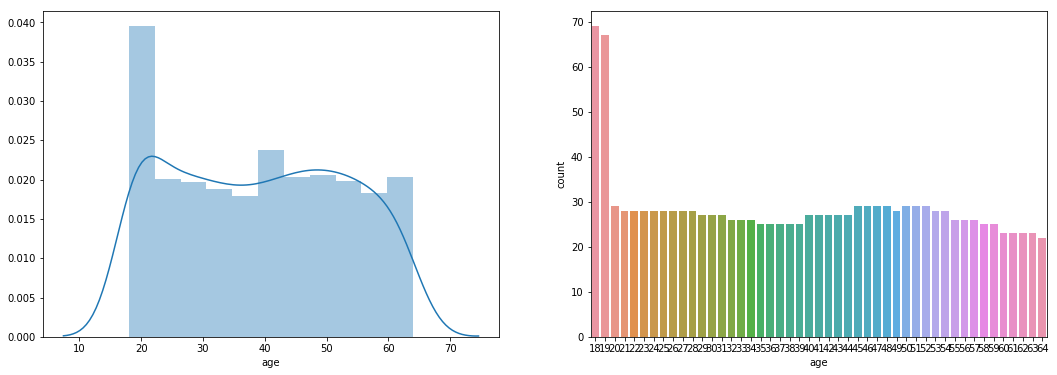

In [23]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
sns.distplot(insurance_df['age'],ax=ax1) 
sns.countplot(insurance_df['age'],ax=ax2) 
plt.show()

In [24]:
insurance_df['age'].skew()

0.054780773126998195

In [25]:
insurance_df['age'].kurtosis()

-1.244406407567826

Surprisingly, the Age distribution shows people of lower age group like 18,19 have more medical records entry. 

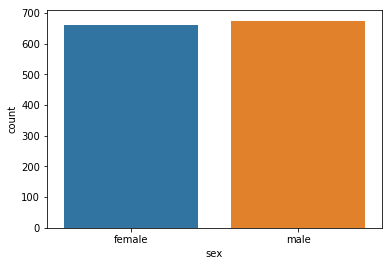

In [26]:
#fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
sns.countplot(insurance_df['sex'])

Male count seems a bit more than Female counts.

In [27]:
insurance_df['sex'].value_counts()

male      675
female    662
Name: sex, dtype: int64

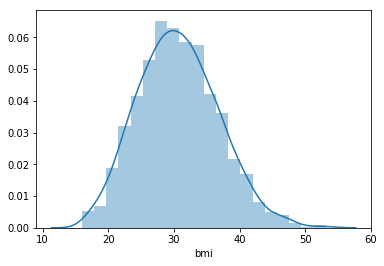

In [28]:
sns.distplot(insurance_df['bmi'],kde=True,bins=20)

BMI is slightly right skewed also we know there are outliers

In [29]:
insurance_df['bmi'].skew() # +vely skewed data

0.28391419385321137

In [30]:
insurance_df['bmi'].kurtosis()

-0.052947204436257334

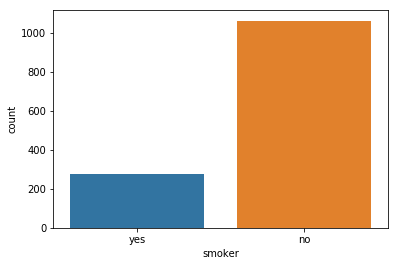

In [31]:
sns.countplot(insurance_df['smoker'])

Non smoker count is looking more. Even though Non smokers count is more but definitely smokers are believed to be paying more bills we will see that in Bivariate Analysis.

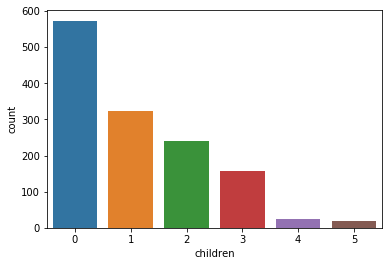

In [32]:
sns.countplot(insurance_df['children'])

The people with 0 children are having more count and it looks obvious as we saw more counts are from people in age group of 18-19 years or so. 

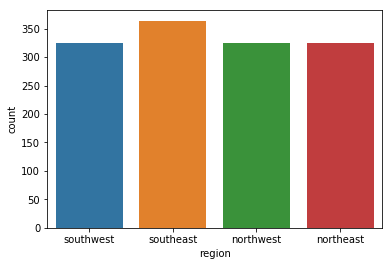

In [33]:
sns.countplot(insurance_df['region'])

We already have seen the southeast data has more records.

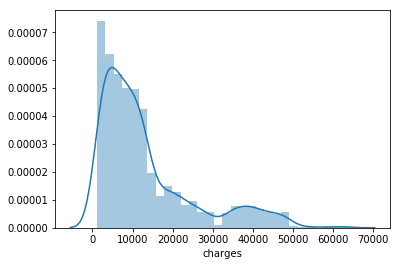

In [34]:
sns.distplot(insurance_df['charges'],kde=True,hist=True,bins=30)

Charges are definitely Rightly Skewed and have outliers too but we will see who leads to more charges.

In [35]:
insurance_df['charges'].skew()

1.5153909108403483

In [36]:
insurance_df['charges'].kurtosis()

1.6042206849514362

Positive Kurtosis and skewness implies that the data has heavy tails and outliers in it.

## Bivariate Analysis

In [37]:
insurance_df.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region', 'charges'], dtype='object')

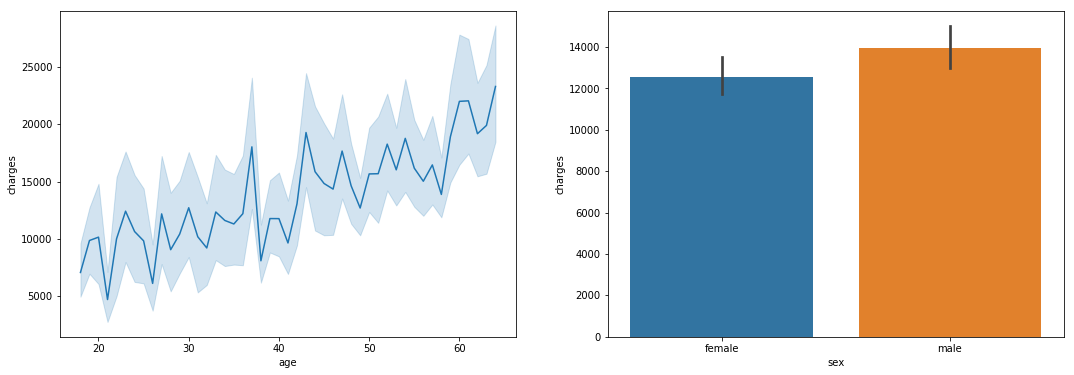

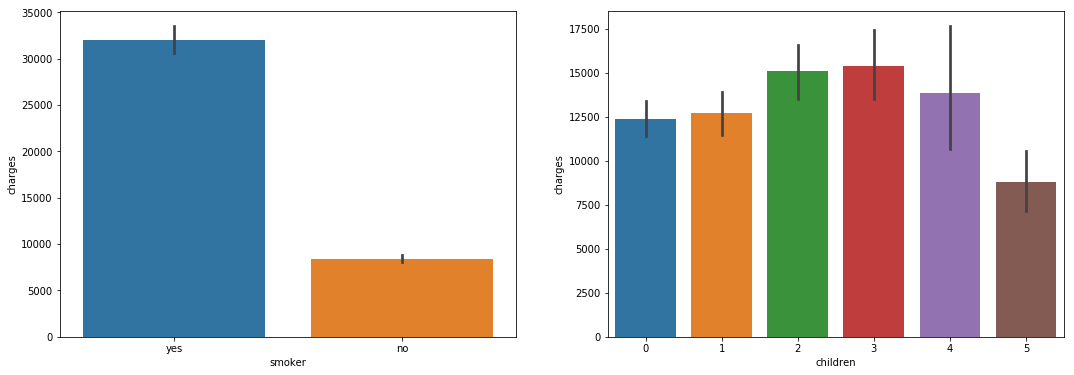

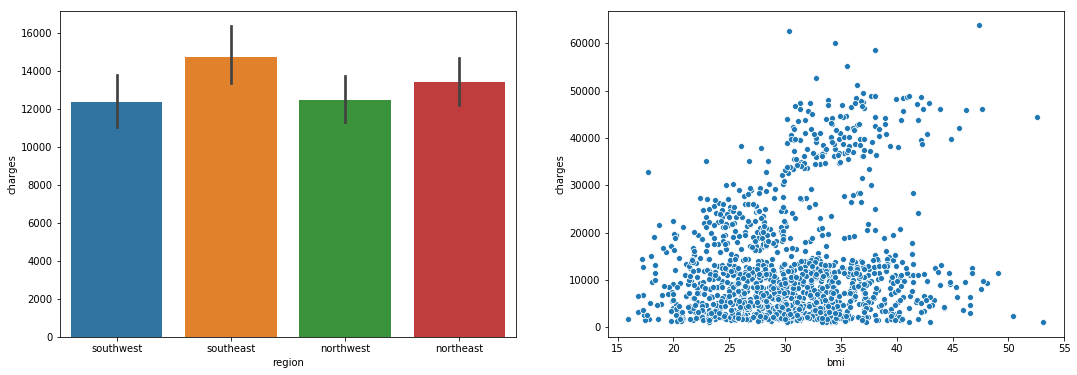

In [38]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
fig, (ax3,ax4) = plt.subplots(ncols=2,figsize=(18,6))
fig, (ax5,ax6) = plt.subplots(ncols=2,figsize=(18,6))

sns.lineplot(insurance_df['age'],insurance_df['charges'],ax=ax1)
sns.barplot(insurance_df['sex'],insurance_df['charges'],ax=ax2)
sns.barplot(insurance_df['smoker'],insurance_df['charges'],ax=ax3)
sns.barplot(insurance_df['children'],insurance_df['charges'],ax=ax4)
sns.barplot(insurance_df['region'],insurance_df['charges'],ax=ax5)
sns.scatterplot(insurance_df['bmi'],insurance_df['charges'],ax=ax6)

> - The trend shows here that the charges are more for higher age group people. The reason is obvious elderly people need more of medical facilities. But seeing the age wise counts we can see the kids must be coming for minor issues like accidents or less illness.
> - More males are having higher medical charges.
> - Yesss! we are correct even though Non-smokers count was more but we knew Smokers are more prone to illness and their charges as expected are high."Smoking is injurious to health"
> - People who have 2-3 kids spend more on medical facilities.
> - As per our records southeast region people are often coming to medicals even have more charges so might be this data is particularly from some agency in this region.
> - With lower or proper BMIs[18.5 to 24.9] the person stays fit and hence obviously with increase in BMI the charges are grwoing up.

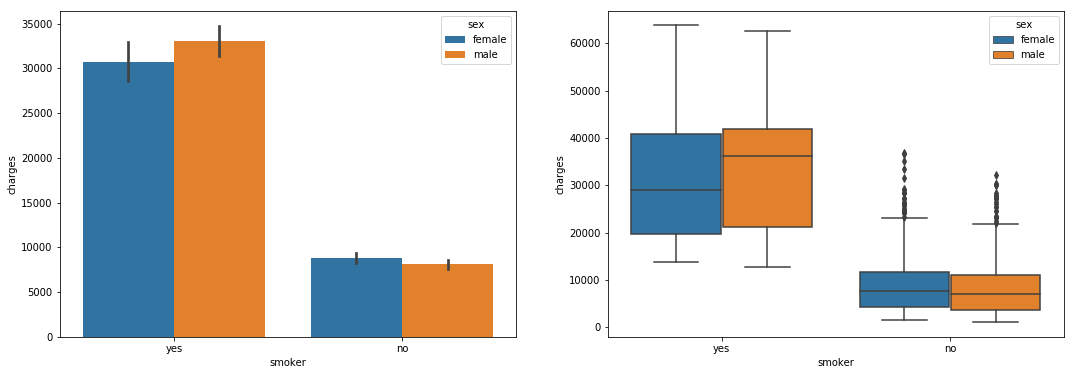

In [39]:
fig, (ax1,ax2) = plt.subplots(ncols=2,figsize=(18,6))
sns.barplot(data=insurance_df,x='smoker',y='charges',hue='sex',ax=ax1)
sns.boxplot(data=insurance_df,x='smoker',y='charges',hue='sex',ax=ax2)

> - This shows that in More of males who are smokers are paying more charges for medical and in Non-smokers category there are more female who has paid more medical charges than males.
> - Also in Non-smokers category there are both males and females who have paid much more charges. and these values probably might be for other reasons like illness or accident etc.

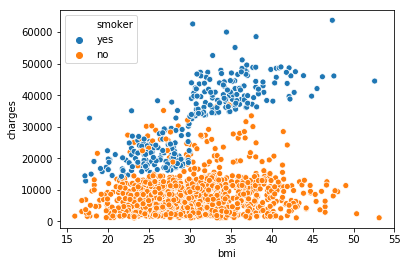

In [40]:
sns.scatterplot(x=insurance_df['bmi'],y=insurance_df['charges'],hue=insurance_df['smoker'])

The lower BMI and with Non-smoker the charges are really low but higher when BMI is high and are smokers.

### Feature Encoding

In [92]:
le = LabelEncoder()
insurance_df['sex'] = le.fit_transform(insurance_df['sex'])
insurance_df['smoker'] = le.fit_transform(insurance_df['smoker'])

We applied label encoder to the binary features with 0 for female and 1 for male. Also we encoded smokers as 1 and Non-smokers as 0.

In [79]:
insurance_df['region'].value_counts()

Series([], Name: region, dtype: int64)

In [93]:
region_map = {'southwest':2, 'southeast':1, 'northwest':3, 'northeast':4} 

In [94]:
insurance_df['region'] = insurance_df['region'].map(region_map)

For the region features we did encoding but in the order of their counts. 1 for highest count and so on.

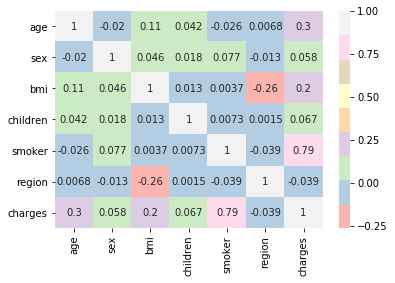

In [45]:
sns.heatmap(insurance_df.corr(),annot=True,cmap='Pastel1')

In [46]:
insurance_df.corr()['charges'].sort_values(ascending=False)

charges     1.000000
smoker      0.787234
age         0.298308
bmi         0.198401
children    0.067389
sex         0.058044
region     -0.039144
Name: charges, dtype: float64

> - charges are highly correlated to smokers followed by age and bmi obviously as expected.
> - bmi has an inverse relation with region not sure of this reason though.
> - age and bmi has a +ve correlation i.e. with age the issues with bmi also increases.

### Data Division

In [95]:
X = insurance_df.drop(columns=['charges'],axis=1) 
# OR 
#X = insurance_df.iloc[:,:6]
Y = insurance_df['charges']
print(X.shape,Y.shape)

(1338, 6) (1338,)


### Train Test Split

In [98]:
X_train,X_test,Y_train,Y_test = train_test_split(X,Y,test_size=0.2,random_state=0)

In [99]:
print(X_train.shape,X_test.shape,Y_train.shape,Y_test.shape)

(1070, 6) (268, 6) (1070,) (268,)


## Feature Scaling

In [100]:
std_scaler = StandardScaler()
X_scaled = pd.DataFrame(std_scaler.fit_transform(X),columns=X.columns,index=X.index)
X_train_scaled = pd.DataFrame(std_scaler.fit_transform(X_train),columns=X_train.columns,index=X_train.index)
X_test_scaled = pd.DataFrame(std_scaler.fit_transform(X_test),columns=X_test.columns,index=X_test.index)

X_test_scaled.head()

,age,sex,bmi,children,smoker,region
578,0.888049,0.893677,-0.035849,-0.132411,-0.508150,-0.488914
610,0.527993,-1.118973,-0.180822,-0.132411,-0.508150,-1.356655
569,0.600004,0.893677,1.774572,0.712498,1.967925,0.378827
1034,1.536149,0.893677,1.392925,-0.977320,-0.508150,0.378827
198,0.816037,-1.118973,-2.158050,-0.977320,-0.508150,0.378827


In [101]:
Y_scaled = pd.DataFrame(std_scaler.fit_transform(Y.values.reshape(-1,1)),columns=['charges'])
Y_train_scaled = pd.DataFrame(std_scaler.fit_transform(Y_train.values.reshape(-1,1)),columns=['charges'])
Y_test_scaled = pd.DataFrame(std_scaler.fit_transform(Y_test.values.reshape(-1,1)),columns=['charges'])
Y_train_scaled.head()

,charges
0,2.253387
1,-1.007529
2,2.113861
3,-0.712448
4,-0.015202


## Modeling

### 1. Linear Regression

In [52]:
linReg = LinearRegression()
linReg.fit(X_train_scaled,Y_train_scaled)
y_linReg_pred = linReg.predict(X_test_scaled)
y_linReg_pred_rescaled = std_scaler.inverse_transform(y_linReg_pred)

In [53]:
rmse_linReg = np.sqrt(mean_squared_error(Y_test,y_linReg_pred_rescaled))
print(rmse_linReg)

6343.697885197981


In [54]:
result = pd.DataFrame({'Y_test':Y_test.ravel(),'Y_predicted':y_linReg_pred_rescaled.ravel()})
result.head()

,Y_test,Y_predicted
0,1633.9618,5039.031730
1,8547.6913,9965.561089
2,9290.1395,12107.740023
3,32548.3405,27250.322625
4,9644.2525,7488.624362


In [55]:
r2_score(Y_test,y_linReg_pred_rescaled)

0.7607881683153407

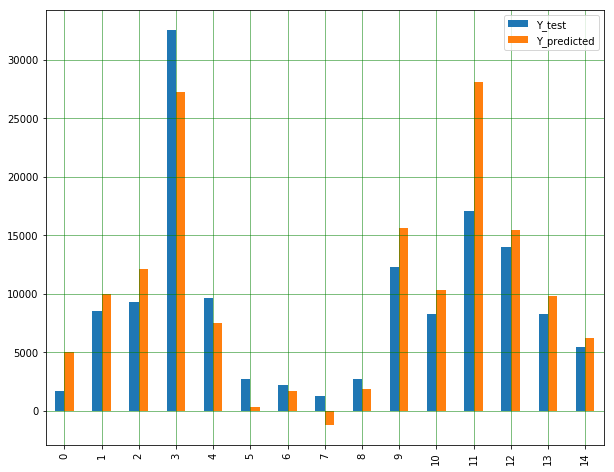

In [56]:
df1=result.head(15)
df1.plot(kind='bar',figsize=(10,8))
plt.grid(which='major', linestyle='-', linewidth='0.5', color='green')
plt.grid(which='minor', linestyle=':', linewidth='0.5', color='black')
plt.show()

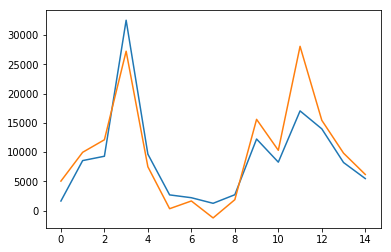

In [57]:
# plot to see the fitting of the prediction.
plt.plot(df1['Y_test'])
plt.plot(df1['Y_predicted'])

The relative good fit here shows that the our linear model is a good fit.

In [58]:
#To plot the relation between one variable to another in data and prediction but its not applicable for Multiple Linear Regression
# plt.scatter(X_test['children'], Y_test, color='red')
# plt.plot(X_test['children'], y_linReg_pred_rescaled , color= 'blue')
# plt.title('Salary vs Experience (training set) ')
# plt.xlabel('year of experiance')
# plt.ylabel('salary')
# plt.show()

## 2. Polynomial Regressions

In [59]:
# Degree = 2
poly_feat = PolynomialFeatures(degree=2)
X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)
poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)
y_train_predicted = poly_model.predict(X_train_poly)
y_test_predicted = poly_model.predict(X_test_poly)
rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)
rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predicted))
r2_test = r2_score(Y_test, y_test_predicted)
print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

RMSE of training set is 4663.320324556248
R2 score of training set is 0.8456874296238641
RMSE of test set is 5305.340145770208
R2 score of test set is 0.8326891368200317


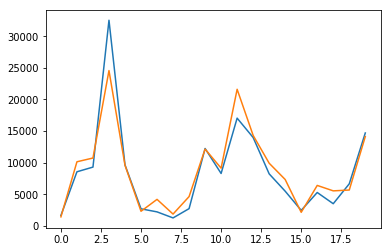

In [60]:
result_2 = pd.DataFrame({'Y_test':Y_test.ravel(),'Y_pred':y_test_predicted.ravel()})
df2 = result_2.head(20)
plt.plot(df2['Y_test'])
plt.plot(df2['Y_pred'])

In [61]:
# Degree = 3
poly_feat = PolynomialFeatures(degree=3)

X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)

y_train_predicted = poly_model.predict(X_train_poly)
y_test_predicted = poly_model.predict(X_test_poly)

rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)

rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predicted))
r2_test = r2_score(Y_test, y_test_predicted)

print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

RMSE of training set is 4756.334817054648
R2 score of training set is 0.8394702067955105
RMSE of test set is 5696.919421227656
R2 score of test set is 0.8070797453961043


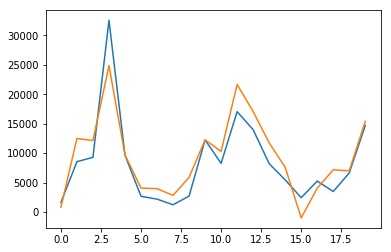

In [62]:
result_3 = pd.DataFrame({'Y_test':Y_test.ravel(),'Y_pred':y_test_predicted.ravel()})
df2 = result_3.head(20)
plt.plot(df2['Y_test'])
plt.plot(df2['Y_pred'])

In [63]:
# Degree = 4
poly_feat = PolynomialFeatures(degree=4)

X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)

y_train_predicted = poly_model.predict(X_train_poly)
y_test_predicted = poly_model.predict(X_test_poly)

rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)

rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predicted))
r2_test = r2_score(Y_test, y_test_predicted)

print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

RMSE of training set is 4221.113679094036
R2 score of training set is 0.8735657008684643
RMSE of test set is 6216.8954869650515
R2 score of test set is 0.7702556679439456


In [64]:
# Degree = 5
poly_feat = PolynomialFeatures(degree=5)

X_train_poly = poly_feat.fit_transform(X_train)
X_test_poly = poly_feat.fit_transform(X_test)

poly_model = LinearRegression()
poly_model.fit(X_train_poly, Y_train)

y_train_predicted = poly_model.predict(X_train_poly)
y_test_predicted = poly_model.predict(X_test_poly)

rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)

rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predicted))
r2_test = r2_score(Y_test, y_test_predicted)

print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

RMSE of training set is 4149.096601831856
R2 score of training set is 0.8778431284895427
RMSE of test set is 11285.912111400137
R2 score of test set is 0.2428690480541006


In [65]:
# Degree = 1 i.e. Linear Regression
lr = LinearRegression()
lr.fit(X_train, Y_train)

y_train_predicted = lr.predict(X_train)
y_test_predicted = lr.predict(X_test)

rmse_train = np.sqrt(mean_squared_error(Y_train, y_train_predicted))
r2_train = r2_score(Y_train, y_train_predicted)

rmse_test = np.sqrt(mean_squared_error(Y_test, y_test_predicted))
r2_test = r2_score(Y_test, y_test_predicted)

print("RMSE of training set is {}".format(rmse_train))
print("R2 score of training set is {}".format(r2_train))
print("RMSE of test set is {}".format(rmse_test))
print("R2 score of test set is {}".format(r2_test))

RMSE of training set is 5951.559364221019
R2 score of training set is 0.7486537856351421
RMSE of test set is 6439.660264107431
R2 score of test set is 0.7534962191024543


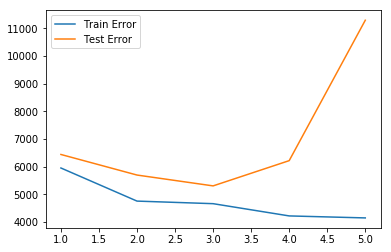

In [66]:
X = [1,2,3,4,5]
y = [5951.559364221019,4756.334817054648,4663.320324556248,4221.113679094036,4149.096601831856]
y1 = [6439.660264107431,5696.919421227656,5305.340145770208,6216.8954869650515,11285.912111400137]
plt.plot(X,y,label = "Train Error")
#plt.legend("Train Error")
plt.plot(X,y1,label = "Test Error")
plt.legend()
plt.show()

As we see here clearly we find that just Linear Regression was an Underfit model and when we more towards Polynomial Regression of degree 2 or 3 we find better performance and when degree grows it becomes Overfitting model.So in this scene it looks like __Polynomial regression of degree =3 is the best fit__ for us.
As we see here as the model complexity increase we have low training error or "Low Bias" but also the result varies mores from the test error i.e. High Variance.

## Cross Validation in Linear Regression

In [96]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,random_state=0)
rmse_cv_linear = np.sqrt(np.mean(np.abs((cross_val_score(linReg,X,Y,cv=kfold,scoring='neg_mean_squared_error')))))
r2_score_cv_linear = np.sqrt(np.mean(np.abs((cross_val_score(linReg,X,Y,cv=kfold,scoring='r2')))))
print("RMSE of Cross validated Linear Regression is {}".format(rmse_cv_linear))
print("R2 score of Cross validated Linear Regression set is {}".format(r2_score_cv_linear))

RMSE of Cross validated Linear Regression is 6070.251361213362
R2 score of Cross validated Linear Regression set is 0.8644535682103809


### Cross Validation in Linear Regression with scaled data

In [102]:
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
kfold = KFold(n_splits=5,random_state=0)
rmse_cv_linear = np.sqrt(np.mean(np.abs((cross_val_score(linReg,X_scaled,Y_scaled,cv=kfold,scoring='neg_mean_squared_error')))))
r2_score_cv_linear = np.sqrt(np.mean(np.abs((cross_val_score(linReg,X,Y,cv=kfold,scoring='r2')))))
print("RMSE of Cross validated Linear Regression is {}".format(rmse_cv_linear))
print("R2 score of Cross validated Linear Regression set is {}".format(r2_score_cv_linear))

RMSE of Cross validated Linear Regression is 0.5014463586934271
R2 score of Cross validated Linear Regression set is 0.8644535682103809


### Lasso Regression using GridSearchCV

In [103]:
from sklearn.linear_model import Lasso
from sklearn.model_selection import GridSearchCV

lasso = Lasso()
parameters = {'alpha':[1e-15,1e-10,1e-5,1e-4,0.0001,0.001,0.01,0.1,1.0,10,20,30,40,50,100]}
gscv_lasso = GridSearchCV(estimator=lasso,param_grid=parameters,cv=5,scoring='neg_mean_squared_error')
gscv_lasso.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Lasso(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.0001, 0.0001, 0.001, 0.01, 0.1, 1.0, 10, 20, 30, 40, 50, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [104]:
gscv_lasso.best_params_

{'alpha': 40}

In [105]:
rmse_lasso= np.sqrt(gscv_lasso.best_score_*(-1))
print(rmse_lasso)

6067.642966310301


In [106]:
lasso = Lasso(alpha=40)
lasso.fit(X,Y)
lasso.coef_ # used for feature selection

array([  256.70063327,    -0.        ,   337.29352065,   445.69699373,
       23600.52859525,   330.89193015])

In [107]:
X.columns

Index(['age', 'sex', 'bmi', 'children', 'smoker', 'region'], dtype='object')

### Ridge Regression using GridSearchCV

In [108]:
from sklearn.linear_model import Ridge
from sklearn.model_selection import GridSearchCV

ridge = Ridge()
parameters = {'alpha':[1e-15,1e-10,1e-5,1e-4,0.0001,0.001,0.01,0.2,0.3,0.4,0.1,1.0,10,100]}
gscv_ridge = GridSearchCV(estimator=ridge,param_grid=parameters,cv=5,scoring='neg_mean_squared_error')
gscv_ridge.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=Ridge(alpha=1.0, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.0001, 0.0001, 0.001, 0.01, 0.2, 0.3, 0.4, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [109]:
gscv_ridge.best_params_

{'alpha': 0.3}

In [110]:
rmse_ridge= np.sqrt(gscv_ridge.best_score_*(-1))
print(rmse_ridge)

6070.050279892931


In [111]:
ridge = Ridge(alpha=0.3)
ridge.fit(X,Y)
ridge.coef_

array([  256.68979929,  -129.04875822,   340.61093358,   473.24927734,
       23828.89337328,   369.27305194])

### ElasticNet Regression

In [112]:
from sklearn.linear_model import ElasticNet
from sklearn.model_selection import GridSearchCV

enet = ElasticNet()
parameters = {'alpha':[1e-15,1e-10,1e-5,1e-4,0.0001,0.001,0.01,0.2,0.3,0.4,0.1,1.0,10,100]}
gscv_enet = GridSearchCV(estimator=enet,param_grid=parameters,cv=5,scoring='neg_mean_squared_error')
gscv_enet.fit(X,Y)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=ElasticNet(alpha=1.0, copy_X=True, fit_intercept=True, l1_ratio=0.5,
      max_iter=1000, normalize=False, positive=False, precompute=False,
      random_state=None, selection='cyclic', tol=0.0001, warm_start=False),
       fit_params=None, iid='warn', n_jobs=None,
       param_grid={'alpha': [1e-15, 1e-10, 1e-05, 0.0001, 0.0001, 0.001, 0.01, 0.2, 0.3, 0.4, 0.1, 1.0, 10, 100]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [113]:
gscv_enet.best_params_

{'alpha': 0.0001}

In [114]:
gscv_enet.best_score_

-36845668.59372002

In [115]:
rmse_enet = np.sqrt(gscv_enet.best_score_*(-1))
print(rmse_enet)

6070.063310519918


In [116]:
enet = ElasticNet(alpha=0.0001)
enet.fit(X,Y)
enet.coef_

array([  256.7062307 ,  -130.70648845,   340.62888288,   473.24201842,
       23854.59338846,   369.69501051])

## DecisionTree Regression

In [117]:
from sklearn.tree import DecisionTreeRegressor
dtree_reg = DecisionTreeRegressor(criterion='mse',max_depth=5)
#parameters = {'max_depth'=[2,3,4,5,6,10,15,18,20]}
dtree_reg.fit(X_train,Y_train)
y_pred_dtree = dtree_reg.predict(X_test)
rmse_dtree = np.sqrt(mean_squared_error(Y_test,y_pred_dtree))
print(rmse_dtree)

5126.515147557306


In [118]:
from sklearn.tree import export_graphviz
export_graphviz(dtree_reg,out_file='dtree.text',feature_names=X_train.columns)
# with the generated grph go to http://www.webgraphviz.com/ and generate the graph.

## RandomForest Regression

In [119]:
from sklearn.ensemble import RandomForestRegressor
rf_reg = RandomForestRegressor()
#parameters = {'max_depth'=[2,3,4,5,6,10,15,18,20]}
rf_reg.fit(X_train,Y_train)
y_pred_rf = rf_reg.predict(X_test)
rmse_rf = np.sqrt(mean_squared_error(Y_test,y_pred_rf))
print(rmse_rf)

4650.732301839681


In [120]:
pd.DataFrame(rf_reg.feature_importances_,index=X_train.columns,columns=['Feature_Importance']).sort_values(by=['Feature_Importance'],ascending=False)

,Feature_Importance
smoker,0.591774
bmi,0.228386
age,0.138153
children,0.021286
region,0.015206
sex,0.005194


Hence, the most important feature here are : Smoker > BMI > Age > Children and so on. 

### KNN Regression

In [121]:
from sklearn.neighbors import KNeighborsRegressor
errors = []
for i in range(1,50):
    knn_reg = KNeighborsRegressor(n_neighbors=i)
    mse_cv_knn = cross_val_score(knn_reg,X_scaled,Y_scaled,cv=5,scoring='neg_mean_squared_error')
    rmse_knn_error = np.sqrt(np.mean(mse_cv_knn*(-1)))
    errors.append(rmse_knn_error)

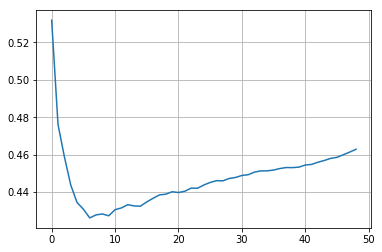

In [122]:
plt.grid()
plt.plot(errors)

At n_neighbours=6 or 7, we get the least rmse so we will go ahead and confirm it with number of neighbours=[5,10]

In [123]:
from sklearn.neighbors import KNeighborsRegressor
errors = []
for i in range(5,10):
    knn_reg = KNeighborsRegressor(n_neighbors=i)
    mse_cv_knn = cross_val_score(knn_reg,X_scaled,Y_scaled,cv=5,scoring='neg_mean_squared_error')
    rmse_knn_error = np.sqrt(np.mean(mse_cv_knn*(-1)))
    errors.append(rmse_knn_error)

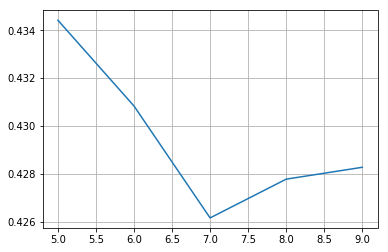

In [124]:
plt.grid()
plt.plot(range(5,10),errors)

Thus, the n_neighbours are found at values n_neighbours=7.

In [125]:
knn_reg = KNeighborsRegressor(n_neighbors=7)
knn_reg.fit(X_train_scaled,Y_train_scaled)
y_knn_pred = knn_reg.predict(X_test_scaled)
y_knn_rescaled = std_scaler.inverse_transform(y_linReg_pred)
rmse_knn = np.sqrt(mean_squared_error(Y_test,y_knn_rescaled))
print(rmse_knn)

13034.726317002895


### AdaBoost

In [126]:
from sklearn.ensemble import AdaBoostRegressor
from sklearn.model_selection import RandomizedSearchCV

param_dist = {
 'n_estimators': [50, 100],
 'learning_rate' : [0.01,0.05,0.1,0.3,1],
 'loss' : ['linear', 'square', 'exponential']
 }

rcv_adaboost = RandomizedSearchCV(AdaBoostRegressor(),
 param_distributions = param_dist,
 cv=3,
 n_iter = 10,
 n_jobs=-1)

rcv_adaboost.fit(X_train, Y_train)

RandomizedSearchCV(cv=3, error_score='raise-deprecating',
          estimator=AdaBoostRegressor(base_estimator=None, learning_rate=1.0, loss='linear',
         n_estimators=50, random_state=None),
          fit_params=None, iid='warn', n_iter=10, n_jobs=-1,
          param_distributions={'n_estimators': [50, 100], 'learning_rate': [0.01, 0.05, 0.1, 0.3, 1], 'loss': ['linear', 'square', 'exponential']},
          pre_dispatch='2*n_jobs', random_state=None, refit=True,
          return_train_score='warn', scoring=None, verbose=0)

In [127]:
rcv_adaboost.best_params_

{'n_estimators': 50, 'loss': 'exponential', 'learning_rate': 0.01}

In [128]:
rcv_adaboost.best_score_

0.8404732486417832

In [129]:
ada_boost_reg = AdaBoostRegressor(n_estimators=100,loss='exponential',learning_rate=0.01)
ada_boost_reg.fit(X_train_scaled,Y_train_scaled)
y_ada_pred = ada_boost_reg.predict(X_test_scaled)
y_ada_rescaled = std_scaler.inverse_transform(y_ada_pred)
rmse_ada = np.sqrt(mean_squared_error(Y_test,y_ada_rescaled))
print(rmse_ada)

4605.928780253701


### GradientBoosting

In [130]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import GradientBoostingRegressor
GBR=GradientBoostingRegressor()
search_grid={'n_estimators':[500,1000,2000],'learning_rate':[.001,0.01,.1],'max_depth':[1,2,4],'subsample':[.5,.75,1],'random_state':[1]}
search=GridSearchCV(estimator=GBR,param_grid=search_grid,scoring='neg_mean_squared_error',n_jobs=1,cv=5)
search.fit(X_train, Y_train)

GridSearchCV(cv=5, error_score='raise-deprecating',
       estimator=GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_sampl...=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'n_estimators': [500, 1000, 2000], 'learning_rate': [0.001, 0.01, 0.1], 'max_depth': [1, 2, 4], 'subsample': [0.5, 0.75, 1], 'random_state': [1]},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='neg_mean_squared_error', verbose=0)

In [131]:
search.best_params_

{'learning_rate': 0.01,
 'max_depth': 2,
 'n_estimators': 1000,
 'random_state': 1,
 'subsample': 0.75}

In [132]:
gbr_reg = GradientBoostingRegressor(learning_rate=0.01,max_depth=2,n_estimators=1000,random_state=1,subsample=0.75)
gbr_reg.fit(X_train_scaled,Y_train_scaled)
y_pred_gbr = gbr_reg.predict(X_test_scaled)
y_gbr_rescaled = std_scaler.inverse_transform(y_pred_gbr)
rmse_gbr = np.sqrt(mean_squared_error(Y_test,y_gbr_rescaled))
print(rmse_gbr)

4150.05370677097


### XGboost

In [133]:
!pip install XGboost

In [134]:
import xgboost as xgb

In [136]:
xgbr = xgb.XGBRegressor(verbosity=0) 
xgbr.fit(X_train_scaled,Y_train_scaled)
y_pred_xgb = xgbr.predict(X_test_scaled)
y_xgb_rescaled = std_scaler.inverse_transform(y_pred_xgb)
rmse_xgb = np.sqrt(mean_squared_error(Y_test,y_xgb_rescaled))
print(rmse_xgb)

4259.140963822569
